<a href="https://colab.research.google.com/github/khykelly-cloud/mul/blob/main/%EC%84%9C%EC%9A%B8%EC%82%AC%EB%B6%84%EB%A9%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

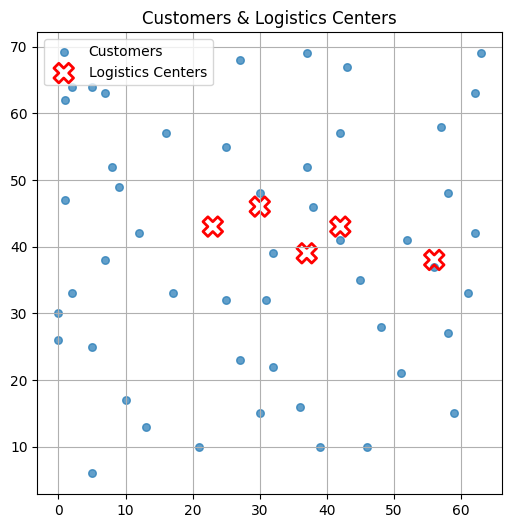

In [13]:
import matplotlib.pyplot as plt

customers_df = pd.read_csv("Customer.csv")
centers_df   = pd.read_csv("DistributionCenter.csv")

plt.figure(figsize=(6,6))

plt.scatter(customers_df["X"], customers_df["Y"],
            s=30, alpha=0.7, label="Customers")

plt.scatter(centers_df["X"], centers_df["Y"],
            marker="X", s=200, linewidths=2,
            edgecolors="red", facecolors="none",
            label="Logistics Centers")

plt.legend()
plt.grid(True)
plt.title("Customers & Logistics Centers")
plt.show()


In [14]:
# ============================================================
# 0. 라이브러리 임포트
# ============================================================
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from itertools import combinations
from math import sqrt, ceil
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import matplotlib.pyplot as plt

# ============================================================
# 1. 데이터 불러오기
# ============================================================
cust = pd.read_csv("Customer.csv")
truck_df = pd.read_csv("Truck.csv")
dc = pd.read_csv("DistributionCenter.csv")

cust_xy = cust[["X", "Y"]].values              # 고객 좌표 (N x 2)
dc_xy = dc[["X", "Y"]].values                  # 물류센터 후보 좌표 (M x 2)
demands = cust["DEMAND"].astype(int).values    # 고객 수요
truck_capacity = int(truck_df.loc[0, "CAPACITY"])

N = len(cust_xy)
M = len(dc_xy)
print("고객 수:", N, "/ 물류센터 후보지 수:", M, "/ 트럭 적재용량:", truck_capacity)


고객 수: 50 / 물류센터 후보지 수: 5 / 트럭 적재용량: 160


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50864 (\N{HANGUL SYLLABLE U}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/loca

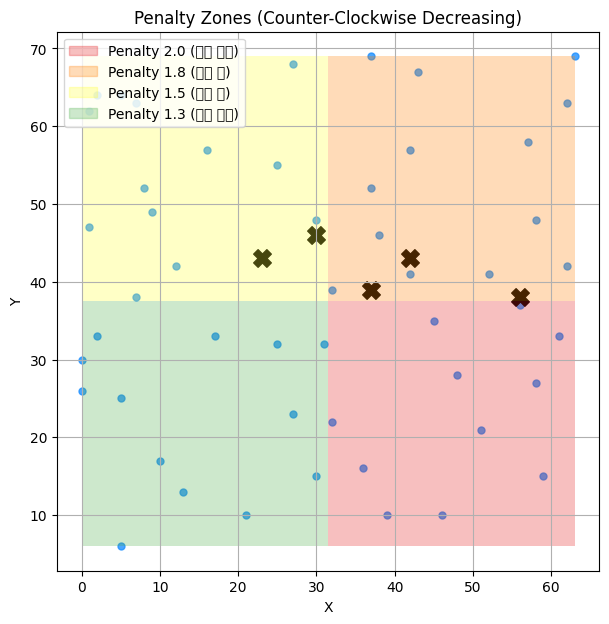

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# --------------------------------------------------
# 1. 구간 기준 계산
# --------------------------------------------------
x_min, x_max = cust_xy[:,0].min(), cust_xy[:,0].max()
y_min, y_max = cust_xy[:,1].min(), cust_xy[:,1].max()

x_mid = (x_min + x_max) / 2.0
y_mid = (y_min + y_max) / 2.0

# --------------------------------------------------
# 2. 패널티 (반시계 방향 2.0 → 1.8 → 1.5 → 1.3)
# --------------------------------------------------
P_BR = 2.0   # 우측 아래 (시작점)
P_TR = 1.8   # 우측 위
P_TL = 1.5   # 좌측 위
P_BL = 1.3   # 좌측 아래

def get_penalty(x, y):
    if y <= y_mid:  # 아래쪽
        if x > x_mid:
            return P_BR   # 우측 아래
        else:
            return P_BL   # 좌측 아래
    else:           # 위쪽
        if x > x_mid:
            return P_TR   # 우측 위
        else:
            return P_TL   # 좌측 위

# --------------------------------------------------
# 3. 시각화
# --------------------------------------------------
fig, ax = plt.subplots(figsize=(7,7))

# 고객
ax.scatter(cust_xy[:,0], cust_xy[:,1], s=25,
           color='dodgerblue', alpha=0.8, label='Customers')

# 센터
ax.scatter(dc_xy[:,0], dc_xy[:,1], marker='X',
           s=160, color='black', label='Logistics Centers')

# 색상(확실히 구분되도록)
C_BR = "#e41a1c"   # 빨강 (2.0)
C_TR = "#ff7f00"   # 주황 (1.8)
C_TL = "#ffff33"   # 노랑 (1.5)
C_BL = "#4daf4a"   # 초록 (1.3)

# 우측 아래 (2.0)
ax.add_patch(Rectangle((x_mid, y_min),
                       x_max-x_mid, y_mid-y_min,
                       linewidth=0, facecolor=C_BR, alpha=0.28))

# 우측 위 (1.8)
ax.add_patch(Rectangle((x_mid, y_mid),
                       x_max-x_mid, y_max-y_mid,
                       linewidth=0, facecolor=C_TR, alpha=0.28))

# 좌측 위 (1.5)
ax.add_patch(Rectangle((x_min, y_mid),
                       x_mid-x_min, y_max-y_mid,
                       linewidth=0, facecolor=C_TL, alpha=0.28))

# 좌측 아래 (1.3)
ax.add_patch(Rectangle((x_min, y_min),
                       x_mid-x_min, y_mid-y_min,
                       linewidth=0, facecolor=C_BL, alpha=0.28))

# 범례
legend_handles = [
    mpatches.Patch(color=C_BR, alpha=0.28, label=f"Penalty 2.0 (우측 아래)"),
    mpatches.Patch(color=C_TR, alpha=0.28, label=f"Penalty 1.8 (우측 위)"),
    mpatches.Patch(color=C_TL, alpha=0.28, label=f"Penalty 1.5 (좌측 위)"),
    mpatches.Patch(color=C_BL, alpha=0.28, label=f"Penalty 1.3 (좌측 아래)")
]

ax.legend(handles=legend_handles, loc='upper left')
ax.set_title("Penalty Zones (Counter-Clockwise Decreasing)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.grid(True)
plt.show()


In [16]:
import pandas as pd

# ------------------------------------------
# 1. customer DataFrame 복사
# ------------------------------------------
df = cust.copy()

# ------------------------------------------
# 2. 사분면 Zone 이름 정의
# ------------------------------------------
def get_zone_name(x, y):
    if y <= y_mid:  # 아래
        if x > x_mid:
            return "BR"   # 우측 아래
        else:
            return "BL"   # 좌측 아래
    else:           # 위
        if x > x_mid:
            return "TR"   # 우측 위
        else:
            return "TL"   # 좌측 위

# ------------------------------------------
# 3. zone & penalty 계산
# ------------------------------------------
zones = []
penalties = []

for x, y in cust_xy:
    zone = get_zone_name(x, y)
    zones.append(zone)

    if zone == "BR": penalties.append(P_BR)
    elif zone == "TR": penalties.append(P_TR)
    elif zone == "TL": penalties.append(P_TL)
    else: penalties.append(P_BL)

df["ZONE"] = zones
df["PENALTY"] = penalties

# ------------------------------------------
# 4. CSV 파일로 저장
# ------------------------------------------
df.to_csv("Customer_with_zone.csv", index=False)

print(">>> Customer_with_zone.csv 저장 완료!")
print(df.head())


>>> Customer_with_zone.csv 저장 완료!
    X   Y  DEMAND ZONE  PENALTY
0  37  52       7   TR      1.8
1   9  49      30   TL      1.5
2   2  64      16   TL      1.5
3   0  26       9   BL      1.3
4   0  30      21   BL      1.3
